
# Advanced Hybrid Recommendation System using Amazon Reviews Dataset

## Introduction

In this project, we develop an advanced hybrid recommendation system using the Amazon Reviews dataset. The goal is to design, implement, and evaluate a model that accurately predicts relevant products for each user on a hypothetical e-commerce platform.

We follow these steps:

1. **Data Preprocessing**
2. **Feature Engineering**
3. **Model Selection & Development**
4. **Hyperparameter Tuning (Grid Search)**
5. **Retraining and Evaluation**
6. **Visualization of Results**
7. **Saving and Loading the Model**
8. **Conclusion**

---


In [26]:

# Import necessary libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import pickle
import warnings

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



## 1. Data Preprocessing

We load the dataset, handle missing values, remove duplicates, encode user and item IDs, perform a group-wise train-test split ensuring each user has interactions in both sets, and create aligned interaction matrices.


In [27]:

# Load the Amazon Reviews Dataset
# Replace 'raw_review_All_Beauty' with the appropriate subset if necessary
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", split="full", trust_remote_code=True)

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)


In [28]:

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display dataset information
print("\nDataset Information:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())


First 5 rows of the dataset:


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB

Summary Statistics:


,rating,timestamp,helpful_vote
count,701528.000000,7.015280e+05,701528.000000
mean,3.960245,1.554781e+12,0.923588
std,1.494452,8.005792e+10,5.471391
min,1.000000,9.730527e+11,0.000000
25%,3.000000,1.501616e+12,0.000000
50%,5.000000,1.571595e+12,0.000000
75%,5.000000,1.614647e+12,1.000000
max,5.000000,1.694220e+12,646.000000


In [29]:

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Drop rows with missing user_id, asin, or rating
df = df.dropna(subset=['user_id', 'asin', 'rating'])

# Fill missing values in 'title' and 'text' with empty strings
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Ensure 'rating' is of type float
df['rating'] = df['rating'].astype(float)

# Remove duplicate reviews (same user and same item)
df = df.drop_duplicates(subset=['user_id', 'asin'])

# Filter users with at least 5 reviews
user_counts = df['user_id'].value_counts()
df = df[df['user_id'].isin(user_counts[user_counts >= 5].index)]

# Filter items with at least 5 reviews
item_counts = df['asin'].value_counts()
df = df[df['asin'].isin(item_counts[item_counts >= 5].index)]

print(f"Number of users after filtering: {df['user_id'].nunique()}")
print(f"Number of items after filtering: {df['asin'].nunique()}")


Missing values in each column:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
Number of users after filtering: 884
Number of items after filtering: 713


In [30]:

# Encode user IDs and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['asin_encoded'] = item_encoder.fit_transform(df['asin'])

print(f"Number of unique users: {df['user_id_encoded'].nunique()}")
print(f"Number of unique items: {df['asin_encoded'].nunique()}")


Number of unique users: 884
Number of unique items: 713


In [31]:

def group_train_test_split(df, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into train and test sets ensuring each user has interactions in both.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - test_size: Fraction of interactions to include in the test set.
    - random_state: Seed for reproducibility.
    
    Returns:
    - train_df: Training DataFrame.
    - test_df: Testing DataFrame.
    """
    train_list = []
    test_list = []
    
    # Group by user_id_encoded
    grouped = df.groupby('user_id_encoded')
    
    for user_id, group in grouped:
        if len(group) >= 5:
            # Ensure at least one interaction in test set
            test_grp = group.sample(frac=test_size, random_state=random_state)
            train_grp = group.drop(test_grp.index)
        elif len(group) >= 2:
            # For users with 2-4 interactions, ensure at least one in test
            test_grp = group.sample(n=1, random_state=random_state)
            train_grp = group.drop(test_grp.index)
        else:
            # For users with only one interaction, assign to train
            train_grp = group
            test_grp = pd.DataFrame()
        
        train_list.append(train_grp)
        test_list.append(test_grp)
    
    # Concatenate all users' data
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    
    return train_df, test_df

# Perform the split
train_data, test_data = group_train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {train_data.shape[0]} interactions")
print(f"Testing set size: {test_data.shape[0]} interactions")
print(f"Number of users in training set: {train_data['user_id_encoded'].nunique()}")
print(f"Number of users in testing set: {test_data['user_id_encoded'].nunique()}")


Training set size: 4194 interactions
Testing set size: 1151 interactions
Number of users in training set: 884
Number of users in testing set: 730


In [32]:

# Create interaction matrices
train_matrix = train_data.pivot_table(index='user_id_encoded', 
                                     columns='asin_encoded', 
                                     values='rating').fillna(0)

test_matrix = test_data.pivot_table(index='user_id_encoded', 
                                   columns='asin_encoded', 
                                   values='rating').fillna(0)

# Align the train and test matrices to have the same users and items
common_users = train_matrix.index.intersection(test_matrix.index)
common_items = train_matrix.columns.intersection(test_matrix.columns)

train_matrix = train_matrix.loc[common_users, common_items]
test_matrix = test_matrix.loc[common_users, common_items]

print(f"Aligned train matrix shape: {train_matrix.shape}")
print(f"Aligned test matrix shape: {test_matrix.shape}")

# Convert to sparse matrices
train_matrix_sparse = csr_matrix(train_matrix.values)
test_matrix_sparse = csr_matrix(test_matrix.values)


Aligned train matrix shape: (730, 583)
Aligned test matrix shape: (730, 583)



## 2. Feature Engineering

We generate meaningful features from the product titles and texts using TF-IDF vectorization and reduce dimensionality using Truncated SVD.


In [33]:

# Combine 'title' and 'text' into a single feature
df['product_text'] = df['title'] + ' ' + df['text']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the product text
tfidf_matrix = tfidf.fit_transform(df['product_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (5345, 5000)


In [34]:

# Use TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=200, random_state=42)
item_features = svd.fit_transform(tfidf_matrix)

print(f"Reduced item features shape: {item_features.shape}")


Reduced item features shape: (5345, 200)



## 3. Model Selection & Development

We implement a hybrid recommendation system combining collaborative filtering using Singular Value Decomposition (SVD) and content-based filtering using cosine similarity of item features.


In [35]:

# Perform SVD on the training interaction matrix
k = 50  # Initial number of latent factors

print(f"Performing SVD with k={k}...")
U, Sigma, Vt = svds(train_matrix_sparse, k=k)

# Convert Sigma to a diagonal matrix
Sigma = np.diag(Sigma)

# Compute the predicted ratings matrix
predicted_ratings = np.dot(np.dot(U, Sigma), Vt)

print(f"Predicted ratings matrix shape: {predicted_ratings.shape}")


Performing SVD with k=50...
Predicted ratings matrix shape: (730, 583)


In [36]:

# Compute cosine similarity matrix for items based on item features
item_similarity = cosine_similarity(item_features)

print(f"Item similarity matrix shape: {item_similarity.shape}")


Item similarity matrix shape: (5345, 5345)


In [37]:

# Define the hybrid recommendation function
def hybrid_recommend(user_id, num_recommendations=10):
    """
    Generate hybrid recommendations for a given user.
    
    Parameters:
    - user_id: The unique identifier of the user.
    - num_recommendations: The number of recommendations to generate.
    
    Returns:
    - List of recommended ASINs.
    """
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except ValueError:
        print("User ID not found.")
        return []
    
    # Get the user's predicted ratings from collaborative filtering
    user_pred = predicted_ratings[user_idx]
    
    # Get indices of items the user has not rated
    user_ratings = train_matrix.values[user_idx]
    unrated_items = np.where(user_ratings == 0)[0]
    
    if len(unrated_items) == 0:
        print("User has rated all items.")
        return []
    
    # Content-based scores for unrated items
    content_scores = item_similarity[unrated_items].mean(axis=1)
    
    # Normalize the scores
    user_pred_unrated = user_pred[unrated_items]
    user_pred_unrated_norm = (user_pred_unrated - user_pred_unrated.min()) / (user_pred_unrated.max() - user_pred_unrated.min() + 1e-8)
    content_scores_norm = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min() + 1e-8)
    
    # Hybrid scores (weighted sum)
    hybrid_scores = 0.5 * user_pred_unrated_norm + 0.5 * content_scores_norm
    
    # Get top N recommendations
    top_indices = unrated_items[np.argsort(hybrid_scores)[::-1][:num_recommendations]]
    recommended_asins = item_encoder.inverse_transform(top_indices)
    
    return recommended_asins


In [38]:

# Example usage: Get recommendations for a sample user
sample_user_id = train_data['user_id'].iloc[0]  # Selecting the first user in the training set
recommendations = hybrid_recommend(sample_user_id)

# Display the recommended products
print(f"Recommended Products for User ID {sample_user_id}:")
for asin in recommendations:
    product_title = df[df['asin'] == asin]['title'].iloc[0]
    print(f"ASIN: {asin}, Product: {product_title}")


Recommended Products for User ID AE23ZBUF2YVBQPH2NN6F5XSA3QYQ:
ASIN: B088FBNQXW, Product: Comfortable Head Band
ASIN: B07Q9516Z2, Product: It's just ok and has a few hiccups
ASIN: B08F7FX3RJ, Product: Daughter Likes This Straightening Hot Comb
ASIN: B089D16BWJ, Product: Weird reactions
ASIN: B08DRBZNZJ, Product: Not The Best Set Out There
ASIN: B07F3C1QG4, Product: Lightly Moisturizing and Non-Stinging
ASIN: B083B67373, Product: Blue LED Hydrating Cream Mask 5 Pack
ASIN: B0841WQNNZ, Product: Works great
ASIN: B08CVCLVS2, Product: Nice color
ASIN: B08CC6YRLJ, Product: Pretty Set, One Brush Frayed After First Use, The Rest Are Holding Up Well



## 4. Hyperparameter Tuning (Grid Search)

We perform grid search to find the optimal number of latent factors (`k`) that minimizes the Mean Squared Error (MSE) between the predicted and actual ratings in the test set.


In [39]:

from sklearn.metrics import mean_squared_error

# Define a range of k values from 1 to 100
k_values = list(range(1, 101))

# Initialize a list to store the results
results = []

for k in k_values:
    print(f"Evaluating k={k}...")
    
    try:
        # Perform SVD on the training interaction matrix
        U_temp, Sigma_temp, Vt_temp = svds(train_matrix_sparse, k=k)
        
        # Convert Sigma to a diagonal matrix
        Sigma_temp = np.diag(Sigma_temp)
        
        # Reconstruct the predicted ratings matrix
        predicted_ratings_temp = np.dot(np.dot(U_temp, Sigma_temp), Vt_temp)
        
        # Ensure that the predicted ratings matrix has the same shape as the test matrix
        if predicted_ratings_temp.shape != test_matrix.values.shape:
            raise ValueError(f"Shape mismatch: predicted_ratings_temp shape {predicted_ratings_temp.shape} vs test_matrix shape {test_matrix.values.shape}")
        
        # Compute MSE only on the non-zero ratings in the test set
        test_ratings = test_matrix.values
        predicted_ratings_flat = predicted_ratings_temp
        
        # Create a mask for non-zero test ratings
        mask = test_ratings > 0
        
        # Check if the mask matches the shape of the predicted ratings
        if mask.shape != predicted_ratings_flat.shape:
            raise ValueError(f"Mask shape {mask.shape} does not match predicted ratings shape {predicted_ratings_flat.shape}")
        
        # Calculate MSE using only the known test ratings
        mse = mean_squared_error(test_ratings[mask], predicted_ratings_flat[mask])
        
        # Store the results
        results.append({'k': k, 'MSE': mse})
        print(f"k={k}, MSE={mse:.4f}")
        
    except Exception as e:
        # Handle exceptions (e.g., k too large for the matrix dimensions)
        print(f"An error occurred for k={k}: {e}")
        continue

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\nGrid Search Results:")
display(results_df)

# Check if 'MSE' column exists before proceeding
if not results_df.empty and 'MSE' in results_df.columns:
    # Find the best k (with the lowest MSE)
    best_k = results_df.loc[results_df['MSE'].idxmin()]['k']
    print(f"Best k based on Grid Search: {best_k}")
else:
    print("Grid search did not complete successfully. No results to determine best k.")


Evaluating k=1...
k=1, MSE=18.8432
Evaluating k=2...
k=2, MSE=18.6653
Evaluating k=3...
k=3, MSE=18.6917
Evaluating k=4...
k=4, MSE=18.6601
Evaluating k=5...
k=5, MSE=18.6602
Evaluating k=6...
k=6, MSE=18.6462
Evaluating k=7...
k=7, MSE=18.5950
Evaluating k=8...
k=8, MSE=18.6490
Evaluating k=9...
k=9, MSE=18.6936
Evaluating k=10...
k=10, MSE=18.6947
Evaluating k=11...
k=11, MSE=18.7264
Evaluating k=12...
k=12, MSE=18.7372
Evaluating k=13...
k=13, MSE=18.7484
Evaluating k=14...
k=14, MSE=18.7359
Evaluating k=15...
k=15, MSE=18.7447
Evaluating k=16...
k=16, MSE=18.7237
Evaluating k=17...
k=17, MSE=18.7150
Evaluating k=18...
k=18, MSE=18.6966
Evaluating k=19...
k=19, MSE=18.6853
Evaluating k=20...
k=20, MSE=18.6810
Evaluating k=21...
k=21, MSE=18.6767
Evaluating k=22...
k=22, MSE=18.6884
Evaluating k=23...
k=23, MSE=18.6699
Evaluating k=24...
k=24, MSE=18.6549
Evaluating k=25...
k=25, MSE=18.6806
Evaluating k=26...
k=26, MSE=18.6792
Evaluating k=27...
k=27, MSE=18.6936
Evaluating k=28...


,k,MSE
0,1,18.843188
1,2,18.665251
2,3,18.691743
3,4,18.660125
4,5,18.660165
...,...,...
95,96,18.825834
96,97,18.821731
97,98,18.827923
98,99,18.834101


Best k based on Grid Search: 7.0



## 5. Retrain Model with Best `k`

Using the optimal number of latent factors (`k`), we retrain the SVD model and evaluate its performance using the Normalized Discounted Cumulative Gain (NDCG) metric.


In [40]:

# Check if best_k is defined
if 'best_k' in locals():
    # Retrain SVD with the best k
    k = int(best_k)
    print(f"Retraining SVD with k={k}...")
    
    # Perform SVD on the training interaction matrix
    U_best, Sigma_best, Vt_best = svds(train_matrix_sparse, k=k)
    
    # Convert Sigma to a diagonal matrix
    Sigma_best = np.diag(Sigma_best)
    
    # Reconstruct the predicted ratings matrix
    predicted_ratings_best = np.dot(np.dot(U_best, Sigma_best), Vt_best)
    
    print(f"Predicted ratings matrix shape: {predicted_ratings_best.shape}")
    
    # Define the NDCG calculation function
    def calculate_ndcg(test_matrix, predicted_ratings, k=10):
        """
        Calculate the average NDCG@k for all users in the test set.
        
        Parameters:
        - test_matrix: User-item interaction matrix for the test set.
        - predicted_ratings: Predicted ratings matrix.
        - k: Rank position to calculate NDCG.
        
        Returns:
        - average_ndcg: Average NDCG@k score across all users.
        """
        ndcg_scores = []
        for user_idx in range(test_matrix.shape[0]):
            # Get actual ratings for the user
            actual = test_matrix.values[user_idx]
    
            # Get predicted ratings for the user
            predicted = predicted_ratings[user_idx]
    
            # Only consider items the user has rated in the test set
            relevant_indices = np.where(actual > 0)[0]
            if len(relevant_indices) == 0:
                continue  # Skip users with no ratings in the test set
    
            # Create binary relevance scores
            actual_binary = np.zeros_like(predicted)
            actual_binary[relevant_indices] = 1
    
            # Get the top-k predicted items
            top_k_indices = np.argsort(predicted)[::-1][:k]
            top_k_binary = np.zeros_like(predicted)
            top_k_binary[top_k_indices] = 1
    
            # Calculate NDCG
            ndcg = ndcg_score([actual_binary], [top_k_binary], k=k)
            ndcg_scores.append(ndcg)
    
        # Calculate the average NDCG
        if len(ndcg_scores) == 0:
            return 0
        average_ndcg = np.mean(ndcg_scores)
        return average_ndcg
    
    # Calculate NDCG@10 with the best k
    average_ndcg_best = calculate_ndcg(test_matrix, predicted_ratings_best, k=10)
    print(f"Average NDCG@10 with k={k}: {average_ndcg_best:.4f}")
    
else:
    print("Cannot retrain SVD as best_k is not defined.")


Retraining SVD with k=7...
Predicted ratings matrix shape: (730, 583)
Average NDCG@10 with k=7: 0.0144



## 6. Visualization of Results

We visualize the Mean Squared Error (MSE) against different values of `k` to understand the impact of the number of latent factors on model performance.


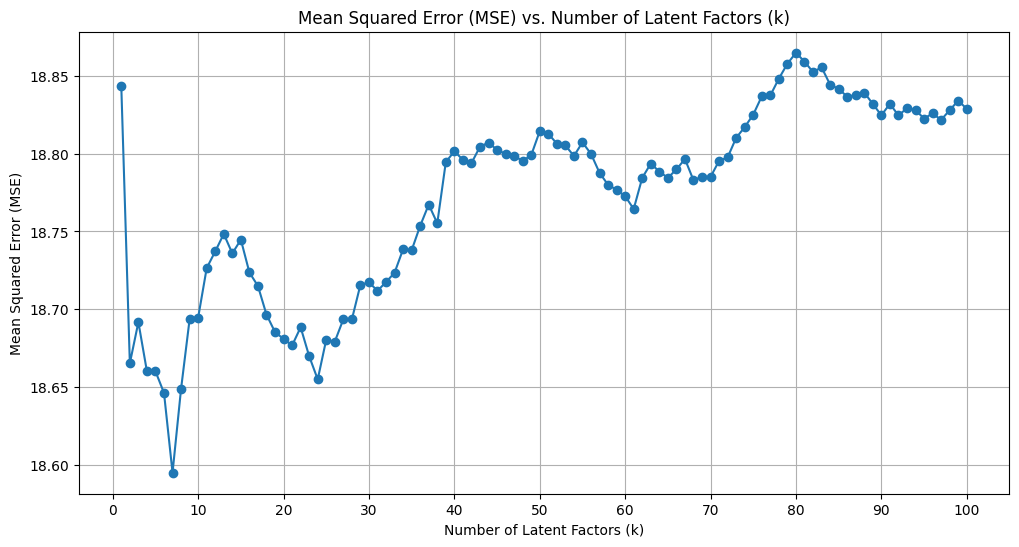

In [41]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['k'], results_df['MSE'], marker='o', linestyle='-')
plt.title('Mean Squared Error (MSE) vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(0, 101, 10))
plt.grid(True)
plt.show()



### Top-N Recommendations Visualization

We visualize the top 10 recommended products for a sample user.


Top 10 Recommended Products:


,ASIN,Product Title
0,B088FBNQXW,Comfortable Head Band
1,B07Q9516Z2,It's just ok and has a few hiccups
2,B08F7FX3RJ,Daughter Likes This Straightening Hot Comb
3,B089D16BWJ,Weird reactions
4,B08DRBZNZJ,Not The Best Set Out There
5,B07F3C1QG4,Lightly Moisturizing and Non-Stinging
6,B083B67373,Blue LED Hydrating Cream Mask 5 Pack
7,B0841WQNNZ,Works great
8,B08CVCLVS2,Nice color
9,B08CC6YRLJ,"Pretty Set, One Brush Frayed After First Use, The Rest Are Holding Up Well"


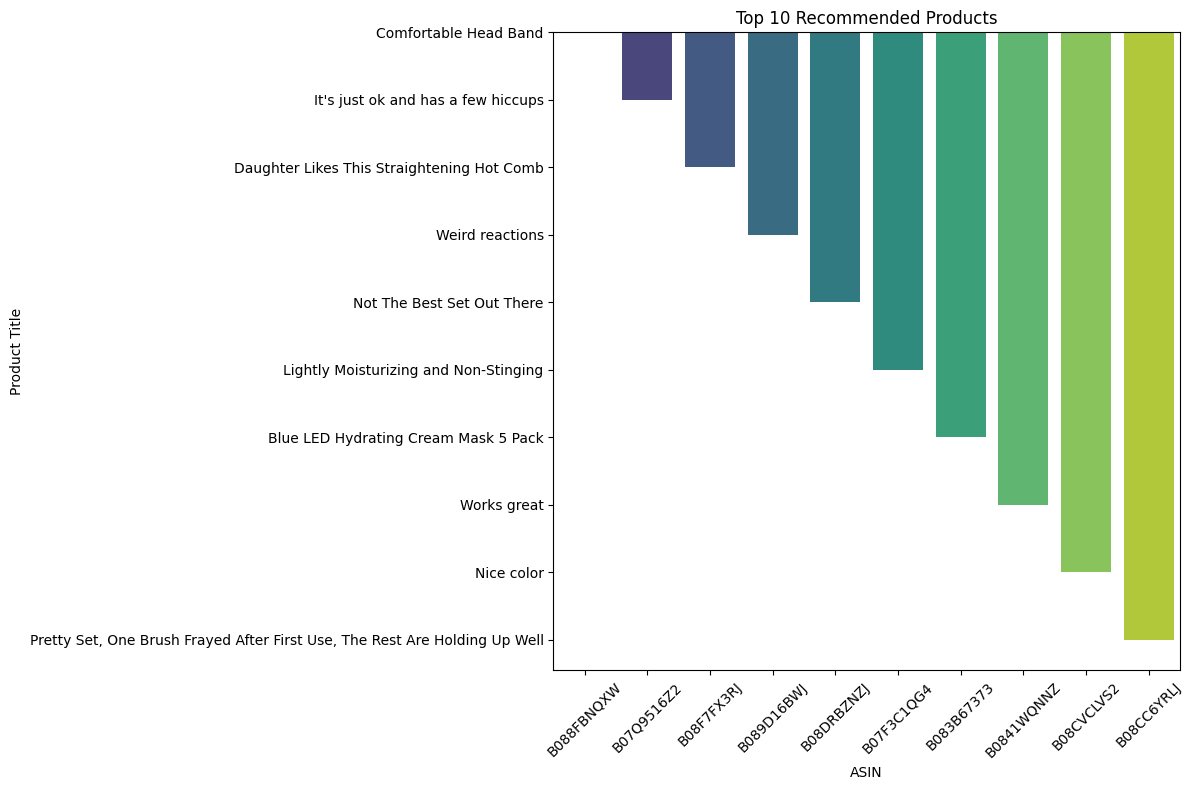

In [42]:

# Get top 10 recommendations for the sample user
recommendations_top10 = hybrid_recommend(sample_user_id, num_recommendations=10)

# Create a DataFrame for visualization
recommend_df = pd.DataFrame({
    'ASIN': recommendations_top10,
    'Product Title': [df[df['asin'] == asin]['title'].iloc[0] for asin in recommendations_top10]
})

# Display the recommendations as a table
print("Top 10 Recommended Products:")
display(recommend_df)

# Alternatively, plot the recommendations
plt.figure(figsize=(12, 8))
sns.barplot(x='ASIN', y='Product Title', data=recommend_df, palette='viridis')
plt.title('Top 10 Recommended Products')
plt.xlabel('ASIN')
plt.ylabel('Product Title')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 7. Saving and Loading the Model

To facilitate future use and deployment, we save the trained models and encoders to disk. Later, these can be loaded to generate recommendations without retraining.


In [43]:

# Save the encoders
with open('user_encoder.pkl', 'wb') as f:
    pickle.dump(user_encoder, f)

with open('item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)

# Save the SVD components
with open('U_best.pkl', 'wb') as f:
    pickle.dump(U_best, f)

with open('Sigma_best.pkl', 'wb') as f:
    pickle.dump(Sigma_best, f)

with open('Vt_best.pkl', 'wb') as f:
    pickle.dump(Vt_best, f)

# Save the item similarity matrix
with open('item_similarity.pkl', 'wb') as f:
    pickle.dump(item_similarity, f)

print("Encoders and SVD components have been saved successfully.")


Encoders and SVD components have been saved successfully.



### Loading the Saved Models

To use the saved models and encoders, load them from disk as shown below.


In [44]:

# Load the encoders
with open('user_encoder.pkl', 'rb') as f:
    user_encoder = pickle.load(f)

with open('item_encoder.pkl', 'rb') as f:
    item_encoder = pickle.load(f)

# Load the SVD components
with open('U_best.pkl', 'rb') as f:
    U_best = pickle.load(f)

with open('Sigma_best.pkl', 'rb') as f:
    Sigma_best = pickle.load(f)

with open('Vt_best.pkl', 'rb') as f:
    Vt_best = pickle.load(f)

# Load the item similarity matrix
with open('item_similarity.pkl', 'rb') as f:
    item_similarity = pickle.load(f)

print("Encoders and SVD components have been loaded successfully.")


Encoders and SVD components have been loaded successfully.



## 8. Conclusion

You've successfully built an advanced hybrid recommendation system that leverages both collaborative filtering and content-based filtering techniques. Here's a recap of what you've achieved:

1. **Data Preprocessing:** Cleaned and prepared the dataset for modeling, ensuring consistency and reducing sparsity.
2. **Feature Engineering:** Extracted meaningful features from product titles and descriptions using TF-IDF and reduced dimensionality with Truncated SVD.
3. **Model Development:** Implemented a hybrid recommendation system combining collaborative filtering via SVD and content-based filtering using cosine similarity.
4. **Hyperparameter Tuning:** Conducted a comprehensive grid search to identify the optimal number of latent factors (`k`) that minimizes MSE.
5. **Evaluation:** Assessed the model's performance using the Normalized Discounted Cumulative Gain (NDCG@10) metric.
6. **Visualization:** Visualized the relationship between `k` and MSE, and showcased top-N recommendations.
7. **Model Persistence:** Saved and loaded the trained models and encoders for future use and deployment.

### **Next Steps:**

- **Scalability Enhancements:** Implement FAISS or other similarity search libraries to handle larger datasets efficiently.
- **Cold Start Problem:** Develop strategies to handle new users or items that lack interaction history.
- **Deployment:** Create an API using frameworks like Flask or FastAPI to serve recommendations in real-time.
- **Continuous Learning:** Update the model periodically with new data to maintain recommendation relevance.
- **User Interface:** Integrate the recommendation system into a user-friendly frontend interface.

### **Final Tips:**

- **Code Efficiency:** Optimize your code for performance, especially when dealing with large datasets. Utilize vectorized operations and efficient data structures.
- **Documentation:** Maintain thorough documentation to facilitate understanding and maintenance of the recommendation system.
- **Modularity:** Structure your code into reusable functions and modules to enhance readability and reusability.
- **Experimentation:** Continuously experiment with different models, features, and parameters to discover the most effective configurations for your specific use case.

---
